# Optimizacion con MAPL + DicsBvals

Lo mismo que 5.1 pero T={C, downs(HR)}
y 


$ min_C { ||GC - Y^{lr}||^2 + ||C||_1 }$


In [1]:
%pylab inline
import time
import numpy as np
import matplotlib.pyplot as plt
from utils import img_utils
import seaborn as sns
import utils.math_utils as mat_utils
#import nibabel as nib
import mapmri.mapmri as mp
#from dipy.core.gradients import gradient_table
import cvxpy as cvx
reload(img_utils)
import load.hcp_img_loader as hcp

Populating the interactive namespace from numpy and matplotlib


In [2]:
def get_sample(index, numbers, loader_func, bval=None, bvalpos=None,  scale=2):
    img, gtab = loader_func(index, numbers, bval, bvalpos)
    hr = img.get_data()
    #(vhr, Nc)
    C = getC(hr, gtab, radial_order = 4)
    lr, lr_affine = img_utils.downsampling(img, scale)
    
    return C, lr, gtab

def get_sample_maker(numbers, loader_func, bval=None, bvalpos=None, scale=2):
    return lambda index : get_sample(index, numbers, loader_func, bval, bvalpos,  scale)

def mm(A, cast_int=True):
    if cast_int :
        return (int(A.min()), int(A.max()))
    else:
        return (A.min(), A.max())
    
def buildT(sample_getter, n_samples):
    noised_hr, noised_lr, _ = sample_getter(0)
    X = img_utils.column_this(noised_lr)
    Y = img_utils.column_this(noised_hr)
    for i in range(1, n_samples):
        noised_hr, noised_lr, _ = sample_getter(i)
        X = img_utils.append_column(X, noised_lr)
        Y = img_utils.append_column(Y, noised_hr)
    return X, Y

def split_by_bval(img, bvals_needed, gtab, res=None):
    """
    Dada una imagen separa la cuarta dimension segun su vbal
    Y por cada una hace un vector columna
    """
    if res is None:
        res = dict((b, None) for b in bvals_needed)
        
    for i in xrange(len(gtab.bvals)):
        b = gtab.bvals[i]
        if b not in bvals_needed :
            continue
        
        XorY = res[b]
        if XorY is None:
            res[b] = img_utils.column_this(img[:,:,:,i])
        else:
            res[b] = img_utils.append_column(XorY, img[:,:,:,i])
    return res

    

## Example of use
#buildT(get_sample_maker(numbers, scale), n_samples)

## Problem definition


$ \min_{Y^{hr},C} \{ (\sum_{b\in bvals} ||G_{b}Y_{b}^{hr} - Y_{b}^{lr}||^2) + || Y^{lr} - S_0*\phi*C||^2 + ||C||_{1} \}$


## MapMri

In [3]:
def getC(data, gtab, radial_order = 4):
    Nx, Ny, Nz, Nb = data.shape
    vhr =Nx*Ny*Nz
    map_model = mp.MapmriModel(gtab,
                                radial_order=radial_order,
                                laplacian_regularization=True,
                                laplacian_weighting=0.2,
                                anisotropic_scaling=False,
                                dti_scale_estimation=False)
    map_model_fit = map_model.fit(data)
    # (Nx, Ny, Nz, Nc)
    C = map_model_fit.mapmri_coeff
    return C
    
def getM(radial_order, mu, gtab, tau):
    r'''Recovers the reconstructed signal for any qvalue array or
        gradient table.
        '''
    qvals = np.sqrt(gtab.bvals / tau) / (2 * np.pi)
    q = qvals[:, None] * gtab.bvecs
    M = mp.mapmri_isotropic_phi_matrix(radial_order, mu[0], q)
    return  M

def get_mapl_params(gtab, radial_order = 4):
    #Fiteo el model
    map_model = mp.MapmriModel(gtab,
                                radial_order=radial_order,
                                laplacian_regularization=True,
                                laplacian_weighting=0.2,
                                anisotropic_scaling=False,
                                dti_scale_estimation=False)
    # Fiteo la data
    #map_model_fit = map_model.fit(i_hr)
    tau = map_model.tau
    mu = map_model.mu
    print 'mu.shape', mu.shape
    M = getM(radial_order, mu, gtab, tau)
    return M, tau, mu

def mapl_predict(gtab, C_or_Cvec, M, tau, Nx=None, Ny=None, Nz=None):
    """
       This method can be used to predit a given q-points (within gtab)
       For a previous fited C or a cvxpy dual variable definition
    """
    is_cvxpy = isinstance(C_or_Cvec, cvx.Variable)
    print 'M.shape', M.shape, 'C.size', C_or_Cvec.size
    Nb, Nc = M.shape
    vhr, Nc = C_or_Cvec.shape if hasattr(C_or_Cvec, 'shape') else C_or_Cvec.size
    #vhr = Nx*Ny*Nz
    
    Cvec = C_or_Cvec
    if not is_cvxpy :
        Cvec = C.reshape((vhr, Nc), order='F')
         
    if is_cvxpy :
        E = (M * Cvec.T)
    else:
        E = np.dot(M, Cvec.T).T
        
    if not is_cvxpy :
        print E.shape,(Nx, Ny, Nz, Nb) 
        E = E.reshape((Nx, Ny, Nz, Nb), order='F')
    #else:
    #    E = E.reshape(-1, order='F')
        
    return E


def cvxpy_mapl(gtab, M, tau, Nc):
    Nx, Ny, Nz, bval = (12, 12, 12, 40)
    vhr = Nx*Ny*Nz
    vhrb = vhr*bval
    
    # Image to fit
    cvxC = cvx.Variable(vhr, Nc)

    cvxMaplE = mapl_predict(gtab, cvxC, M, tau)
    #print 'E.size', cvxE.size

    
    ## objective
    #obj = cvx.Minimize(cvx.sum_squares(cvxE-YhrMap) + alpha*cvx.norm1(cvxC))

    return cvxMaplE, cvxC
    ## some constraints
    # pos_cons =[ cvxM*cvxC[i,:].T >= 0  for i in xrange(vhr) ]
    # max_cons =[ cvxM*cvxC[i,:].T*cvxS0[i] <= i_hr.max() for i in xrange(vhr) ]

In [4]:
def define_problem_with_mapl(i_lr, i_hr_shape, dic_G, M, tau, gtab, scale):
    Nx, Ny, Nz, bval = i_hr_shape
    _, Nc = M.shape
    vlr = Nx*Ny*Nz/(scale**3)
    vlrb = vlr*bval
    vhr = Nx*Ny*Nz
    vhrb = vhr*bval
    
    ## LR volumes
    Ylr = cvx.Parameter(vlr*bval, 1, sign="positive")
    Ylr.value = i_lr.reshape((vlr*bval, 1), order='F')
    
    ## Downsamplings matrixs
    G = dic_G
    
    ## MAPL params
    cvxMaplE, cvxC = cvxpy_mapl(gtab, M, tau, Nc)
    # Hr image in row by b-val
    #YhrMapl = cvx.reshape(Yhr, vhr,bval).T
    
    ## Mapl dual expression
    #cvxMaplDualExp = cvx.sum_squares(cvxMaplE-YhrMapl)
    
    ## Mapl weight
    betha = cvx.Parameter(value=.23, sign='positive')
    ## Sparcity weight
    alpha = cvx.Parameter(value=.15, sign='positive')
    ## Fidelity weight
    gamma = cvx.Parameter(value=.62, sign='positive')
    
    #epsilon = cvx.Parameter(value=1, sign='positive')
    #constraints = [cvxMaplDualExp <= epsilon]
    
    # Constraints
    constraints = []
    # constraints = [Yhr >= 0, mapl <= epsilon*vhr*bval]
    #constraints = [Yhr >= 0, Yhr <= i_lr.max()]
    
    ## Fidelity expression
        
    #print 'G*cvxC - Ylr', G.shape,  cvxC.size , Ylr.size
    cvxFidelityExp = cvx.sum_squares(G*cvx.vec(cvxC) - Ylr)
    
    # Form objective.
    obj = cvx.Minimize(gamma*cvxFidelityExp +alpha*cvx.norm1(cvxC))
    
    # Form and solve problem.
    prob = cvx.Problem(obj, constraints)
    
    return prob, None, Ylr, cvxC, G 

"""
NOTAS:
 - la primera formulacion funciono bastante bien (con la sum de los sum_squears) fue 
   sacado el metodo para preservarlo
 - probe con la lista de constraints de mapl con igualdad dio todos infeasibles
   (proximo a probar lo mismo con desigualdad a un epsilon en vez de igualdad)
 - 
   
"""
print

In [ ]:
def solveMin(i_lr, i_hr_shape, dic_G, M, tau, gtab, scale=2, max_iters=1500, verbose=False):
    Nx, Ny, Nz, Nb = i_hr_shape
    Nb, Nc = M.shape
    prob, Yhr, Ylr, cvxC, G = define_problem_with_mapl(
                                i_lr, 
                                i_hr_shape, 
                                dic_G, 
                                M, tau,
                                gtab,
                                scale)
     
    start_time = time.time()
    print 'asasasa'
    res = prob.solve(solver='SCS', max_iters=max_iters, eps=0.50e-02, verbose=verbose )  # Returns the optimal value.
    seg = time.time() - start_time

    minutes = int(seg / 60)
    print("--- time of optimization : %d' %d'' ---" % (minutes , seg%60))
    print "--- status:", prob.status, "optimal value", prob.value
    print 

    # Change dimension of result representation
    C, A = None, None
    if Yhr.value is None :
        #Yhr.value = np.ones(i_hr_shape)
        print 'FRECONSTRUCTION FAIL :('
        A = np.zeros(i_hr_shape,dtype='float32')
    else:    
        #A = np.asarray(Yhr.value, dtype='float32').reshape(i_hr_shape, order='F')
        C = np.asarray(cvxC.value, dtype='float32').reshape((Nx, Ny, Nz, Nc), order='F')
 
        
    return A, C, seg, prob


## Solving the problem and cross-validation (leave one out)

In [ ]:
from scipy.sparse import csr_matrix
import experimento1_funciones as e1f
reload(e1f)

RES_BASE_FOLDER = './resultados/exp5/'
VMIN, VMAX=-50, 2500

voi_hr_shape = (12, 12, 12, 6)
voi_lr_shape = (6, 6, 6, 6)
#subjects = [100307, 100408, 180129, 180432, 180836, 180937]
subjects = [100307, 100408, 180129]

bvals2000pos = [18, 27, 69, 75, 101, 107]

# Esto es por si quiero alguna S0
#img_s0, gtab_s0 = load_subject_small(0, subjects, bval=5, bvalpos=bvals5pos[0:6])
#i_hr=img.get_data()
#S0 = img_s0.get_data()

reload(hcp)

#print '#Qvals: ', gtab.bvals.shape
#print 'Bvals: ', set(gtab.bvals)
## Con imagenes pequenas multi-shel
loader_func = hcp.load_subject_medium
sample_maker = get_sample_maker(subjects, loader_func, scale=2)
## Con imagenes pequenas single-shel
#loader_func = hcp.load_subject_small
#sample_maker = get_sample_maker(subjects, loader_func,  bval=2000, bvalpos=bvals2000pos, scale=2)

n_samples = 3
iterations = 1

# Metrics to save
min_vals_hr_r = []
max_vals_hr_r = []
min_vals_lr_r = []
max_vals_lr_r = []

dif_norm_hrs=[]
dif_norm_lrs=[]    
Yhr_recons_norms=[]
Ylr_recons_norms=[]  
Yhr_norms=[]
Ylr_norms=[]
times = []
optimal_vals = []

## For save results
# base_folder = RES_BASE_FOLDER
## For NOT save results
base_folder = None

for i in range(0, iterations):
    subjects.append(subjects.pop(0))
    subject = str(subjects[len(subjects)-1])
    print '== Leaving out: #', subject
    
    ## The one that left out to validate
    the_one_out = len(subjects)-1
    C, i_lr, gtab = get_sample(the_one_out, subjects, loader_func, scale=2)
    
    ### Aca shiftear el arreglo de sujetos (train deja el ultimo afuera del entrenamiento)
    lr_samples, hr_samples = buildT(sample_maker, n_samples) #lr, hr

    #lr_samples, hr_samples = lr_samples/1589, hr_samples/1589
    #print 'SAMPLES min/max ', lr_samples.min(),lr_samples.max(),  hr_samples.min(), hr_samples.max()
    
    # Build downsampling matrix
    print '= Training and fiting ...'
    regr, hr_train , lr_train, hr_test, lr_test = e1f.train(hr_samples, lr_samples)
    del(hr_train)
    del(lr_train)
    del(hr_test)
    del(lr_test)
    
    #regr.coef_ = csr_matrix(regr.coef_)
    
    
    #i_lr = lr_test.reshape(voi_lr_shape, order='F')
    #i_hr = hr_test.reshape(voi_hr_shape, order='F')
    
    # Mapl params
    M, tau, mu = get_mapl_params(gtab, radial_order = 4)
    
    # Minimization solve
    # mock: A, seg = np.ones(i_hr.shape), 20
    print '= Solving optimization problem ...'
    A, C, seg, prob = solveMin(i_lr, (12, 12, 12, 40), regr.coef_, M, tau, gtab, scale=2, max_iters=1500, verbose=True)
    max_vals_hr_r.append(A.max())
    min_vals_hr_r.append(A.min())
    
    nx, ny, nz, nb = i_lr.shape
    B = np.zeros((nx, ny, nz, nb))
    for i in xrange(nb):
        b = gtab.bvals[i]
        print 'doing ^i_lr[%d]= G(%d)*i_hr[%d]'%(i, b, i)
        B[:,:,:,i] = (G[b]*i_hr[:,:,:,i].reshape(-1, order='F')).reshape((nx, ny, nz), order='F')
    max_vals_lr_r.append(B.max())
    min_vals_lr_r.append(B.min())
    
    # Keep parameters
    print '= Calculating metrics...'
    dif_norm_hr = np.linalg.norm(i_hr-A) # recons-gtrust
    Yhr_norm = np.linalg.norm(i_hr)
    Yhr_recons_norm = np.linalg.norm(A) #recons
    
    dif_norm_lr = np.linalg.norm(i_lr-B)
    Ylr_norm = np.linalg.norm(B)
    Ylr_recons_norm = np.linalg.norm(B)
    
    dif_norm_hrs.append(dif_norm_hr)
    dif_norm_lrs.append(dif_norm_lr)
    
    Yhr_recons_norms.append(Yhr_recons_norm)
    Ylr_recons_norms.append(Ylr_recons_norm)
    
    Yhr_norms.append(Yhr_norm)
    Ylr_norms.append(Ylr_norm)
    
    times.append(seg)
    optimal_vals.append(prob.value)

    # Save the A calculated
    if base_folder is not None:
        name = base_folder+ "A/" + 'hrRec_lo' + subject
        np.save(name, A)
        print 'showing hr '+ subject, 'min, max',(A.min(), A.max()) 
        titles=['Reconstruida', 'Original']
        for b in xrange(6):
            plt = img_utils._isc(A, i_hr,b=b ,titles=titles,  vmax=VMAX, vmin=VMIN)
            plt.savefig(name +'b'+str(b)+'.pdf')
        print 'saved A in: ', name + str('.npy')
        
    # Save the B calculated
    if base_folder is not None:
        name = base_folder + 'lrRec_lo' + subject
        np.save(name, B)
        print 'showing lr '+ subject, 'min, max',(B.min(), B.max()) 
        titles=['Reconstruida', 'Original']
        plt = img_utils._isc(B, i_lr, titles=titles,  vmax=VMAX, vmin=VMIN)
        plt.savefig(name + '.pdf')
        print 'saved A in: ', name + str('.npy')
        
    print
    print

# Log spended
total_sec = np.array(times).sum()
print ' === TOTAL TIME :',  str(int(total_sec//60))+"'", str(int(total_sec%60))+ '"'

# Persist results
if base_folder is not None: 
    np.save(base_folder+ 'dif_norm_hrs', dif_norm_hrs)
    np.save(base_folder+ 'dif_norm_lrs', dif_norm_lrs)
    np.save(base_folder+ 'Yhr_recons_norms', Yhr_recons_norms)
    np.save(base_folder+ 'Ylr_recons_norms', dif_norm_hrs)
    np.save(base_folder+ 'Yhr_norms', dif_norm_lrs)
    np.save(base_folder+ 'Ylr_norms', Yhr_recons_norms)
    
    np.save(base_folder+ 'max_vals_hr_r', max_vals_hr_r)
    np.save(base_folder+ 'min_vals_hr_r', min_vals_hr_r)
    np.save(base_folder+ 'max_vals_lr_r', max_vals_hr_r)
    np.save(base_folder+ 'min_vals_lr_r', min_vals_hr_r)
    
    np.save(base_folder+ 'times' , times)
    np.save(base_folder+ 'optimal_vals', optimal_vals)


/user/lgomez/home/anaconda2/lib/python2.7/site-packages/skimage/filter/__init__.py:6: skimage_deprecation: The `skimage.filter` module has been renamed to `skimage.filters`.  This placeholder module will be removed in v0.13.
  warn(skimage_deprecation('The `skimage.filter` module has been renamed '


== Leaving out: # 100307
= Training and fiting ...
mu.shape (3,)
= Solving optimization problem ...
M.shape (40, 22) C.size (1728, 22)
asasasa


recons (-40.40028, 1093.9287, 12596.452)
orig (0.0, 1161.6234, 13620.414)
con la primer forma de tvnorm
dif_norm_hrs [532196.56]
dif_norm_lrs [12485.271093917361]
Yhr_recons_norms [716274.44]
Ylr_recons_norms [174205.97541075802]
Yhr_norms [482484.25]
Ylr_norms [174205.97541075802]
times [760.6005840301514]
optimal_vals [1872215.9874908493]


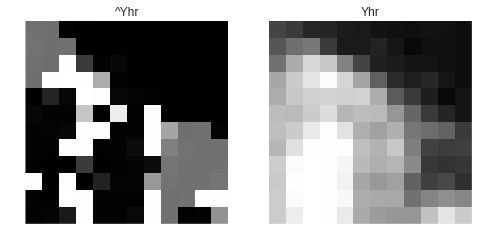

In [8]:
img_utils._isc(A, i_hr, b=1, vmax=np.std(i_hr)+i_hr.mean(), vmin=0, titles=['^Yhr', 'Yhr'])

#img_utils._is(A, vmin=A.min(), vmax=A.max())
print 'recons', (A.min(), A.mean(), A.max())
print 'orig',(i_hr.min(), i_hr.mean(), i_hr.max())
#G.shape

print 'con la primer forma de tvnorm'
print 'dif_norm_hrs', dif_norm_hrs
print 'dif_norm_lrs', dif_norm_lrs   
print 'Yhr_recons_norms', Yhr_recons_norms
print 'Ylr_recons_norms', Ylr_recons_norms
print 'Yhr_norms', Yhr_norms
print 'Ylr_norms', Ylr_norms
print 'times',times
print 'optimal_vals', optimal_vals

<module 'matplotlib.pyplot' from '/user/lgomez/home/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

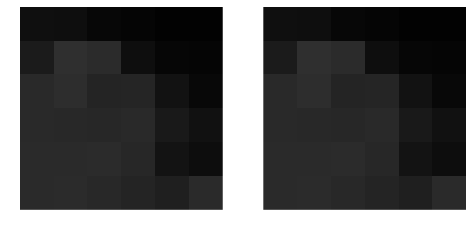

In [8]:
img_utils._isc(B, i_lr, b=4, vmax=max(i_lr.max(), B.max()), vmin=min(i_lr.min(),B.min()))

# HR Testing reconstruction 


mse= 4.0977e+06


((-6, 10374), (89, 1053), (15777, 98600464), 12199003.0)

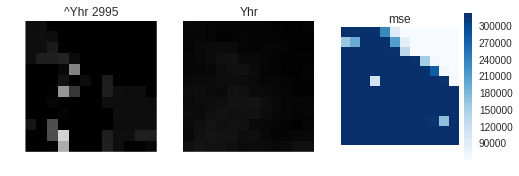

In [32]:
mse = ((A-i_hr)**2).mean(axis=3)
print 'mse=', ((A-i_hr)**2).mean()

bval = 5
titles = ['^Yhr '+str(int(gtab.bvals[bval])), 'Yhr', 'mse']
plt, _, _, im3 = img_utils._isc3(A, i_hr, mse,  b=bval,  vmin=[0, 61104], vmax=[12425, 324973], titles=titles)
plt.colorbar(im3,fraction=0.056, pad=0.04)
mm(A[:,6,:, bval]), mm(i_hr[:,6,:, bval]), mm(mse), mse.mean()+ np.std(mse)

(<Container object of 40 artists>,
 0.89344014176808906,
 0.89014089080400383,
 5.0,
 5.0)

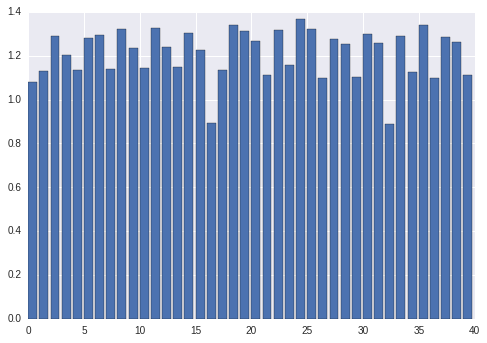

In [23]:
errel = errrel_layers(A, i_hr)
errs =[errel[:,:,:,b].mean() for b in xrange(A.shape[3])]

plt.bar(xrange(A.shape[3]), errs),errs[16], errs[32], gtab.bvals[16], gtab.bvals[32]

# LR Testing reconstruction

$ G*Yhr = Yhr^* $

In [13]:
def errrel_layers(A, B):
    err_rel = np.zeros(A.shape)
    for b in xrange(A.shape[3]):
        err_rel[:,:,:,b] = np.divide(np.abs(A[:,:,:,b]-B[:,:,:,b]), B[:,:,:,b]+0.01)
    return err_rel
    

(6, 6, 6, 6) mse: (0, 22) 0.602017806689 1.4911128861 B: (56, 11659) i_lr: (73, 12425)


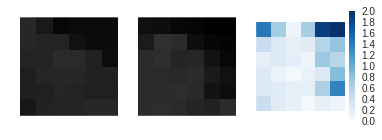

In [212]:
mse_lr = errrel_layers(B,i_lr)
#mse_lr = ((mat_utils.normalize(B)-mat_utils.normalize(i_lr))**2).mean(axis=3)
#mse_lr = ((np.divide(B-i_lr, i_lr))**2).mean(axis=3)
print mse_lr.shape, 'mse:',mm(mse_lr), mse_lr.mean(), np.std(mse_lr), 'B:',mm(B),'i_lr:', mm(i_lr)

reload(img_utils)
plt, _, _, im3 = img_utils._isc3(B, i_lr, mse_lr,  b=4, vmin=[73, 0], vmax=[12000,2],)
plt.colorbar(im3,fraction=0.056, pad=0.04)

# Testing Mapl reconstruction

M.shape (40, 22) C.size 38016
(1728, 40) (12, 12, 12, 40)
(0, 12251)
Error relativo max,min u std (0, 35) 1 1
max/min i_hr: (0, 13620) Eq: (-227, 12707) 1093.13802999


'\nMAPL SALE PAL TRASTE PORQ \nprecisa mas de 6 puntos \n- probar con menos orden \n- probar con minimo 40 puntos y q dios ayude a la compu!!!\n\n'

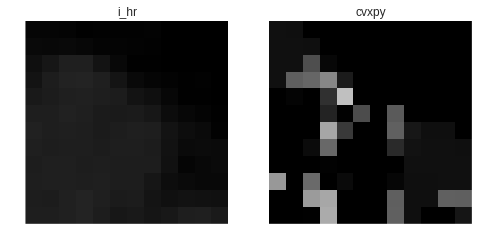

In [33]:
Nx, Ny, Nz, Nb = i_hr.shape
Nb, Nc =  M.shape
Eq_reconst = mapl_predict(gtab, C.reshape((Nx*Ny*Nz, Nc), order='F'), M, tau, Nx, Ny, Nz)


err = np.abs(Eq_reconst - i_hr)
err_rel = np.divide(err, i_hr+1)#para q no de infinito

print mm(err) 
print 'Error relativo max,min u std', mm(err_rel), int(err_rel.mean()), \
                                      int(np.std(err_rel)) 

#img_utils._isc(i_hr, Eq_reconst,b=b, vmin=0, vmax=i_hr.max(), titles=['i_hr', 'cvxpy'])
img_utils._isc(i_hr, Eq_reconst,b=4, vmin=111, vmax=16402, titles=['i_hr', 'cvxpy'])
print 'max/min i_hr:',mm(i_hr),'Eq:', mm(Eq_reconst), Eq_reconst.mean()

"""
MAPL SALE PAL TRASTE PORQ 
precisa mas de 6 puntos 
- probar con menos orden 
- probar con minimo 40 puntos y q dios ayude a la compu!!!

"""


['__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'b0_threshold',
 'b0s_mask',
 'big_delta',
 'bvals',
 'bvecs',
 'gradients',
 'info',
 'qvals',
 'small_delta']